In [1]:
import re
import time
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

from nltk.stem.snowball import SnowballStemmer
from nltk import wordnet, pos_tag, WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1

Загрузим датасет 20newsgroups при помощи метода sklearn.datasets.fetch_20newsgroups. Уберем все заголовки, подписи и цитаты.

In [2]:
twenty = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

Переведем во всех документах все буквы в нижний регистр. Заменим во всех документах символы, не являющиеся буквами и цифрами, на пробелы.

In [3]:
expr = r'[^a-zA-Z0-9]'
parser=re.compile(expr)

def preprocess(sent):
    res = parser.sub(r' ', sent).lower()
    return res

In [4]:
new_data = list(map(preprocess, twenty.data))

# 2

Разделим датасет на обучающую, валидационную и тестовую выборки.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(new_data, twenty.target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Преобразуем датасет с помощью CountVectorizer и TfidfVectorizer.

In [6]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_val_counts = count_vect.transform(X_val)
X_test_counts = count_vect.transform(X_test)

In [7]:
idf_vectorizer = TfidfVectorizer()
X_train_idf = idf_vectorizer.fit_transform(X_train)
X_val_idf = idf_vectorizer.transform(X_val)
X_test_idf = idf_vectorizer.transform(X_test)

Сравним преобразования по качеству классификации при помощи SVM на валидационной выборке. 

In [8]:
svm_counts = SGDClassifier()
svm_counts.fit(X_train_counts, y_train)
predicted_counts = svm_counts.predict(X_val_counts)

In [9]:
print(metrics.classification_report(y_val, predicted_counts,
                                    target_names=twenty.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.49      0.38      0.43       130
           comp.graphics       0.63      0.51      0.57       157
 comp.os.ms-windows.misc       0.58      0.50      0.54       152
comp.sys.ibm.pc.hardware       0.25      0.30      0.28       135
   comp.sys.mac.hardware       0.21      0.79      0.34       160
          comp.windows.x       0.81      0.66      0.73       169
            misc.forsale       0.78      0.72      0.75       162
               rec.autos       0.66      0.58      0.62       152
         rec.motorcycles       0.47      0.49      0.48       165
      rec.sport.baseball       0.74      0.70      0.72       162
        rec.sport.hockey       0.80      0.73      0.76       137
               sci.crypt       0.82      0.66      0.73       161
         sci.electronics       0.84      0.39      0.53       160
                 sci.med       0.90      0.35      0.51       173
         

In [10]:
svm_idf = SGDClassifier()
svm_idf.fit(X_train_idf, y_train)
predicted_idf = svm_idf.predict(X_val_idf)

In [11]:
print(metrics.classification_report(y_val, predicted_idf,
                                    target_names=twenty.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.74      0.57      0.64       130
           comp.graphics       0.71      0.70      0.71       157
 comp.os.ms-windows.misc       0.70      0.69      0.70       152
comp.sys.ibm.pc.hardware       0.69      0.70      0.70       135
   comp.sys.mac.hardware       0.84      0.81      0.83       160
          comp.windows.x       0.81      0.81      0.81       169
            misc.forsale       0.76      0.79      0.78       162
               rec.autos       0.75      0.74      0.75       152
         rec.motorcycles       0.82      0.76      0.79       165
      rec.sport.baseball       0.78      0.86      0.82       162
        rec.sport.hockey       0.56      0.93      0.70       137
               sci.crypt       0.88      0.80      0.83       161
         sci.electronics       0.70      0.75      0.73       160
                 sci.med       0.82      0.85      0.84       173
         

TF-IDF показал лучше качество

Лучший алгоритм применить к тестовой выборке. 

In [12]:
predicted_test_idf = svm_idf.predict(X_test_idf)

In [13]:
print(metrics.classification_report(y_test, predicted_test_idf,
                                    target_names=twenty.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.73      0.63      0.68       161
           comp.graphics       0.75      0.72      0.73       193
 comp.os.ms-windows.misc       0.70      0.75      0.72       205
comp.sys.ibm.pc.hardware       0.75      0.70      0.73       213
   comp.sys.mac.hardware       0.79      0.72      0.76       189
          comp.windows.x       0.81      0.82      0.82       188
            misc.forsale       0.84      0.81      0.82       201
               rec.autos       0.76      0.79      0.77       202
         rec.motorcycles       0.84      0.78      0.81       203
      rec.sport.baseball       0.78      0.85      0.81       185
        rec.sport.hockey       0.63      0.89      0.74       218
               sci.crypt       0.84      0.75      0.80       207
         sci.electronics       0.69      0.65      0.67       181
                 sci.med       0.79      0.89      0.84       195
         

Приведем примеры из тестовой выборки, на которых алгоритм ошибается. 

In [14]:
indices = np.where(predicted_test_idf != y_test)[0]
for i in range(3,6):
    print(X_test[indices[i]])
    print(f"Predicted: {twenty.target_names[predicted_test_idf[indices[i]]]}")
    print(f"True: {twenty.target_names[y_test[indices[i]]]}")

hi there   i think it is time to create a ms dos 6 0  faq since lots of questions about it are actually flooding the net   i won t be able to write it my self because of the lack of time knowledge experience  
Predicted: sci.med
True: comp.sys.ibm.pc.hardware
 i heard the same thing  but without confirmation that he actually said it  it was just as alarming to us as to you  the bible says that nobody knows when the second coming will take place  
Predicted: talk.religion.misc
True: soc.religion.christian
    as opposed to universal or catholic or  foursquare gosple   i think that    the greek orthodox church would take high offense at your misuse of the    word  your version of christianity is neither mainstream nor bible derived    you make claims of bible centricity that are not derivable soley from the    bible   about six seven months ago  you claimed that your primary objection    to the lds was that  our  doctrine was not bible derived  and now this     and other  claims can be s

> (после перезапуска примеры перемешались) В первой паре предсказания-ответа совпали категория comp, по сообщению сложно сказать даже человеку что пользователь ищет видеокарту.
Во второй классы абсолютно различны, видимо по слову encounter svm подумала о столкновениях на дороге и классифицировала в сообщение в мотоциклы.
В третьей совпали подкатегория religion, по сообщению сложно понять к какому классу из 2 оно относится.

Выведем матрицу ошибок (confusion matrix).

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

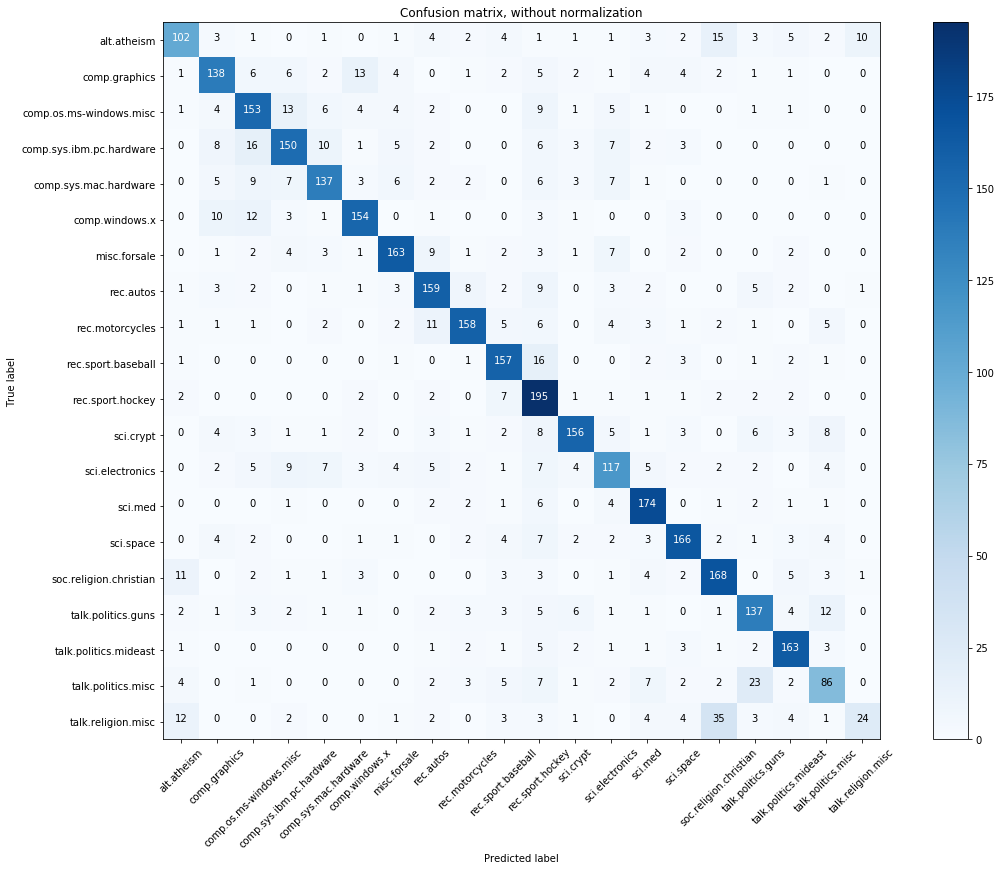

In [16]:
cnf_matrix = metrics.confusion_matrix(y_test, predicted_test_idf)
plt.figure()
f, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(cnf_matrix, classes=twenty.target_names,
                      title='Confusion matrix, without normalization')

plt.show()

> Большинство(~75%) объектов мы правильно классифицировали. Большая часть ошибочных предсказаний связана с похожими классами. Например, talk.religion.misc и soc.religion.christian, talk.politics.misc и talk.politics.guns, подкатегории comp.

# 3

Применим алгоритмы стемминга и лемматизации на датасете 20newsgroups.

In [17]:
stemmer = SnowballStemmer(language='english')
def stem(sent):
    return ' '.join([stemmer.stem(word) for word in sent.split()])

In [18]:
%%time
data_stem = list(map(stem, new_data))

CPU times: user 43 s, sys: 53.3 ms, total: 43.1 s
Wall time: 43.1 s


In [19]:
data_stem[0]

'i am sure some basher of pen fan are pretti confus about the lack of ani kind of post about the recent pen massacr of the devil actual i am bit puzzl too and a bit reliev howev i am go to put an end to non pittsburgh relief with a bit of prais for the pen man they are kill those devil wors than i thought jagr just show you whi he is much better than his regular season stat he is also a lot fo fun to watch in the playoff bowman should let jagr have a lot of fun in the next coupl of game sinc the pen are go to beat the pulp out of jersey anyway i was veri disappoint not to see the island lose the final regular season game pen rule'

In [20]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

In [21]:
lemmatizer = WordNetLemmatizer()
def my_lemmatizer(sent):
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

In [22]:
%%time
data_lemm = list(map(my_lemmatizer, new_data))

CPU times: user 3min 1s, sys: 442 ms, total: 3min 1s
Wall time: 3min 1s


In [23]:
data_lemm[0]

'i be sure some bashers of pen fan be pretty confuse about the lack of any kind of post about the recent pen massacre of the devil actually i be bit puzzled too and a bit relieved however i be go to put an end to non pittsburghers relief with a bit of praise for the pen man they be kill those devil bad than i think jagr just show you why he be much good than his regular season stats he be also a lot fo fun to watch in the playoff bowman should let jagr have a lot of fun in the next couple of game since the pen be go to beat the pulp out of jersey anyway i be very disappointed not to see the islander lose the final regular season game pen rule'

In [24]:
def runIdf(data):
    X_train, X_test, y_train, y_test = train_test_split(data, twenty.target, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    idf_vectorizer = TfidfVectorizer()
    X_train_idf = idf_vectorizer.fit_transform(X_train)
    X_val_idf = idf_vectorizer.transform(X_val)
    X_test_idf = idf_vectorizer.transform(X_test)
    
    svm_idf = SGDClassifier()
    svm_idf.fit(X_train_idf, y_train)
    predicted_idf = svm_idf.predict(X_val_idf)
    
    print(metrics.classification_report(y_val, predicted_idf,
                                    target_names=twenty.target_names))
    print(f"Vocabulary size: {len(idf_vectorizer.vocabulary_)}")

In [25]:
%%time
runIdf(data_stem)

                          precision    recall  f1-score   support

             alt.atheism       0.67      0.52      0.59       130
           comp.graphics       0.75      0.75      0.75       157
 comp.os.ms-windows.misc       0.71      0.70      0.71       152
comp.sys.ibm.pc.hardware       0.70      0.70      0.70       135
   comp.sys.mac.hardware       0.84      0.78      0.81       160
          comp.windows.x       0.80      0.83      0.82       169
            misc.forsale       0.78      0.79      0.79       162
               rec.autos       0.75      0.75      0.75       152
         rec.motorcycles       0.53      0.81      0.64       165
      rec.sport.baseball       0.84      0.86      0.85       162
        rec.sport.hockey       0.88      0.93      0.91       137
               sci.crypt       0.85      0.80      0.82       161
         sci.electronics       0.67      0.71      0.69       160
                 sci.med       0.85      0.83      0.84       173
         

In [26]:
%%time
runIdf(data_lemm)

                          precision    recall  f1-score   support

             alt.atheism       0.68      0.56      0.62       130
           comp.graphics       0.79      0.70      0.74       157
 comp.os.ms-windows.misc       0.74      0.68      0.71       152
comp.sys.ibm.pc.hardware       0.68      0.71      0.69       135
   comp.sys.mac.hardware       0.84      0.79      0.81       160
          comp.windows.x       0.82      0.85      0.83       169
            misc.forsale       0.80      0.78      0.79       162
               rec.autos       0.78      0.74      0.76       152
         rec.motorcycles       0.53      0.80      0.64       165
      rec.sport.baseball       0.82      0.86      0.84       162
        rec.sport.hockey       0.86      0.93      0.90       137
               sci.crypt       0.85      0.76      0.80       161
         sci.electronics       0.65      0.73      0.69       160
                 sci.med       0.78      0.87      0.82       173
         

In [27]:
%%time
# original data without stemming and lemmatization
runIdf(new_data)

                          precision    recall  f1-score   support

             alt.atheism       0.68      0.55      0.61       130
           comp.graphics       0.75      0.66      0.70       157
 comp.os.ms-windows.misc       0.71      0.70      0.71       152
comp.sys.ibm.pc.hardware       0.70      0.70      0.70       135
   comp.sys.mac.hardware       0.80      0.81      0.80       160
          comp.windows.x       0.82      0.81      0.81       169
            misc.forsale       0.76      0.80      0.78       162
               rec.autos       0.78      0.71      0.74       152
         rec.motorcycles       0.80      0.80      0.80       165
      rec.sport.baseball       0.79      0.87      0.83       162
        rec.sport.hockey       0.57      0.93      0.71       137
               sci.crypt       0.88      0.79      0.83       161
         sci.electronics       0.71      0.72      0.72       160
                 sci.med       0.86      0.83      0.85       173
         

> Точность(precision) не изменилась в среднем, однако изменилась для отдельных категорий, talk.politics.misc, например. Время работы алгоритма немного меньше после нормализации. Размер признакового пространства сильно уменьшился после нормализации: после стемминга на ~20к, после лемматизации на ~10к. На то чтобы провести стемминг потребовалось 45сек, на лемматизацию 3мин 16сек.

# 4

Посчитаем частоту слов

In [28]:
word2tfidf = dict(zip(count_vect.get_feature_names(), idf_vectorizer.idf_))

Остортируем словарь по частоте

In [29]:
sorted_vocab = sorted(word2tfidf, key=word2tfidf.get)

In [30]:
# don't run it
# for r in sorted_vocab:
#     print (f'{r}, {word2tfidf[r]}')

Удалим самые частые слова

**На удаление 10000 слов у меня ушло 6 и 12 минут, удалите это не значение, если не хотите ждать.**

In [31]:
numbers = [10, 100, 1000, 10000]

c = 0
def clean(sent):
    return ' '.join([word for word in sent.split() if not word in sorted_vocab[0:numbers[c]]])

for n in numbers:
    print(f'Deleting first {numbers[c]} most frecuent words...')
    tic = time.clock()
    data_clean = list(map(clean, new_data))
    toc = time.clock()
    print(f'Time to clean data: {round((toc - tic), 2)} seconds')
    
    tic = time.clock()
    runIdf(data_clean)
    toc = time.clock()
    print(f'Time to run tf-idf svm: {round((toc - tic), 2)} seconds')
    print('----------------------------------------')
    
    c += 1

Deleting first 10 most frecuent words...
Time to clean data: 1.59 seconds
                          precision    recall  f1-score   support

             alt.atheism       0.73      0.52      0.61       130
           comp.graphics       0.72      0.69      0.70       157
 comp.os.ms-windows.misc       0.74      0.70      0.72       152
comp.sys.ibm.pc.hardware       0.73      0.70      0.71       135
   comp.sys.mac.hardware       0.83      0.81      0.82       160
          comp.windows.x       0.80      0.82      0.81       169
            misc.forsale       0.74      0.79      0.76       162
               rec.autos       0.75      0.71      0.73       152
         rec.motorcycles       0.75      0.79      0.77       165
      rec.sport.baseball       0.86      0.84      0.85       162
        rec.sport.hockey       0.57      0.93      0.71       137
               sci.crypt       0.88      0.80      0.84       161
         sci.electronics       0.70      0.72      0.71       160
 

С удалением часто встречающихся алгоритм работает намного быстрее, однако сама операция удаления затратна. Если мы удалим 10 или 100 самых часто встречающихся слов качество алгоритма не сильно измениться. Если удалить 1000 качество ухудшится не сильно, а если 10000 то очень сильно.  

Удалим самые редкие слова

In [32]:
c = 0
def clean(sent):
    return ' '.join([word for word in sent.split() if not word in sorted_vocab[-numbers[c]:]])

for n in numbers:
    print(f'Deleting last {numbers[c]} most frecuent words...')
    tic = time.clock()
    data_clean = list(map(clean, new_data))
    toc = time.clock()
    print(f'Time to clean data: {round((toc - tic), 2)} seconds')
    
    tic = time.clock()
    runIdf(data_clean)
    toc = time.clock()
    print(f'Time to run tf-idf svm: {round((toc - tic), 2)} seconds')
    print('----------------------------------------')
    
    c += 1

Deleting last 10 most frecuent words...
Time to clean data: 1.73 seconds
                          precision    recall  f1-score   support

             alt.atheism       0.72      0.53      0.61       130
           comp.graphics       0.72      0.70      0.71       157
 comp.os.ms-windows.misc       0.70      0.69      0.70       152
comp.sys.ibm.pc.hardware       0.71      0.73      0.72       135
   comp.sys.mac.hardware       0.86      0.82      0.84       160
          comp.windows.x       0.82      0.80      0.81       169
            misc.forsale       0.52      0.82      0.64       162
               rec.autos       0.76      0.75      0.75       152
         rec.motorcycles       0.73      0.84      0.78       165
      rec.sport.baseball       0.83      0.85      0.84       162
        rec.sport.hockey       0.87      0.93      0.90       137
               sci.crypt       0.88      0.78      0.83       161
         sci.electronics       0.75      0.74      0.74       160
  

Время работы алгоритма не меняется. Качество не изменилось. 

Удалим стоп-слова

In [33]:
sw_eng = set(stopwords.words('english'))

In [34]:
def clean(sent):
    return ' '.join([word for word in sent.split() if not word in sw_eng])

data_clean = list(map(clean, new_data))

In [35]:
%%time
runIdf(data_clean)

                          precision    recall  f1-score   support

             alt.atheism       0.68      0.55      0.61       130
           comp.graphics       0.74      0.69      0.72       157
 comp.os.ms-windows.misc       0.70      0.72      0.71       152
comp.sys.ibm.pc.hardware       0.71      0.72      0.72       135
   comp.sys.mac.hardware       0.84      0.80      0.82       160
          comp.windows.x       0.81      0.82      0.82       169
            misc.forsale       0.77      0.79      0.78       162
               rec.autos       0.83      0.72      0.77       152
         rec.motorcycles       0.54      0.83      0.66       165
      rec.sport.baseball       0.85      0.88      0.86       162
        rec.sport.hockey       0.92      0.92      0.92       137
               sci.crypt       0.88      0.77      0.82       161
         sci.electronics       0.66      0.72      0.69       160
                 sci.med       0.83      0.84      0.84       173
         

Качество не изменилось. Алгоритм стал работать значильно быстрее.

# 4 Дополнительно

## 1 

Проверим использование 2-грамм и 3-грамм.

In [36]:
%%time
idf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_idf = idf_vectorizer.fit_transform(X_train)
X_val_idf = idf_vectorizer.transform(X_val)
X_test_idf = idf_vectorizer.transform(X_test)

svm_idf = SGDClassifier()
svm_idf.fit(X_train_idf, y_train)
predicted_idf = svm_idf.predict(X_val_idf)

print(metrics.classification_report(y_val, predicted_idf,
                                target_names=twenty.target_names))
print(f"Vocabulary size: {len(idf_vectorizer.vocabulary_)}")

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.52      0.62       130
           comp.graphics       0.68      0.68      0.68       157
 comp.os.ms-windows.misc       0.73      0.68      0.71       152
comp.sys.ibm.pc.hardware       0.71      0.67      0.69       135
   comp.sys.mac.hardware       0.81      0.80      0.80       160
          comp.windows.x       0.78      0.84      0.81       169
            misc.forsale       0.77      0.83      0.80       162
               rec.autos       0.79      0.74      0.76       152
         rec.motorcycles       0.81      0.78      0.79       165
      rec.sport.baseball       0.56      0.91      0.69       162
        rec.sport.hockey       0.84      0.94      0.89       137
               sci.crypt       0.84      0.79      0.81       161
         sci.electronics       0.72      0.70      0.71       160
                 sci.med       0.87      0.83      0.85       173
         

In [37]:
%%time
idf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_idf = idf_vectorizer.fit_transform(X_train)
X_val_idf = idf_vectorizer.transform(X_val)
X_test_idf = idf_vectorizer.transform(X_test)

svm_idf = SGDClassifier()
svm_idf.fit(X_train_idf, y_train)
predicted_idf = svm_idf.predict(X_val_idf)

print(metrics.classification_report(y_val, predicted_idf,
                                target_names=twenty.target_names))
print(f"Vocabulary size: {len(idf_vectorizer.vocabulary_)}")

                          precision    recall  f1-score   support

             alt.atheism       0.81      0.48      0.61       130
           comp.graphics       0.70      0.65      0.68       157
 comp.os.ms-windows.misc       0.69      0.72      0.71       152
comp.sys.ibm.pc.hardware       0.70      0.68      0.69       135
   comp.sys.mac.hardware       0.83      0.78      0.81       160
          comp.windows.x       0.76      0.81      0.79       169
            misc.forsale       0.73      0.84      0.78       162
               rec.autos       0.83      0.70      0.76       152
         rec.motorcycles       0.54      0.80      0.65       165
      rec.sport.baseball       0.77      0.85      0.81       162
        rec.sport.hockey       0.82      0.93      0.87       137
               sci.crypt       0.77      0.80      0.79       161
         sci.electronics       0.75      0.67      0.71       160
                 sci.med       0.87      0.83      0.85       173
         

Качество ухудшается, время увеличивается.

## 2

_Закон Ципфа («ранг—частота») — эмпирическая закономерность распределения частоты слов естественного языка: если все слова языка (или просто достаточно длинного текста) упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n (так называемому рангу этого слова, см. шкала порядка)._

In [38]:
values = []

for r in sorted_vocab:
    values.append(1/word2tfidf[r])

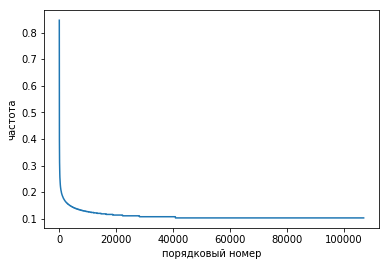

In [39]:
y = values
plt.plot(range(len(y)), y)
plt.ylabel('частота')
plt.xlabel('порядковый номер')
plt.show()

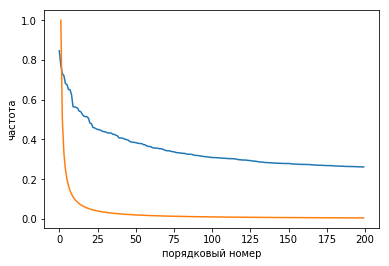

In [40]:
y = values[0:200]
plt.plot(range(len(y)), y)

x2 = list(range(1, 200))
y2 = []
for i in x2:
    y2.append(1/i)

plt.plot(x2, y2)
plt.ylabel('частота')
plt.xlabel('порядковый номер')
plt.show()

Форма похожая, частота приблизительно обратно пропорциональной его порядковому номеру. 

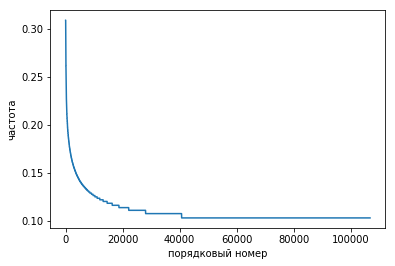

In [41]:
y = values[100:]
plt.plot(range(len(y)), y)
plt.ylabel('частота')
plt.xlabel('порядковый номер')
plt.show()

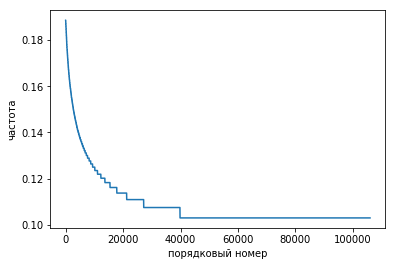

In [42]:
y = values[1000:]
plt.plot(range(len(y)), y)
plt.xlabel('порядковый номер')
plt.ylabel('частота')
plt.show()

Если убрать самые частые слова, форма примерно сохраняется.

_Закон Хипса — эмпирическая закономерность в лингвистике, описывающая распределение числа уникальных слов в документе (или наборе документов) как функцию от его длины._ 

In [43]:
arr = []
for t in new_data:
    n_words = len(t.split())
    n_unique = len(Counter(t.split()))
    arr.append((n_words, n_unique))

In [44]:
s = sorted(arr, key=lambda x: x[0])

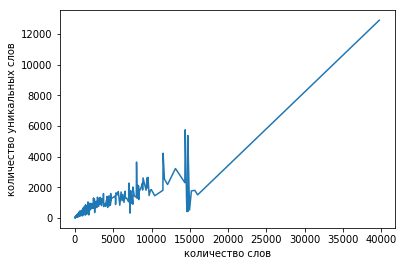

In [45]:
plt.plot(*zip(*s))
plt.xlabel('количество слов')
plt.ylabel('количество уникальных слов')
plt.show()

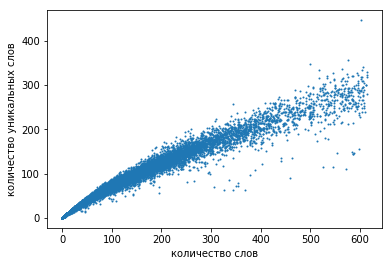

In [46]:
plt.scatter(*zip(*s[0:18000]), s=1)
plt.xlabel('количество слов')
plt.ylabel('количество уникальных слов')
plt.show()

Прослеживается зависимость, число уникальных слов в документе можно описать как функцию от его длины, закон Хипса соблюдается.

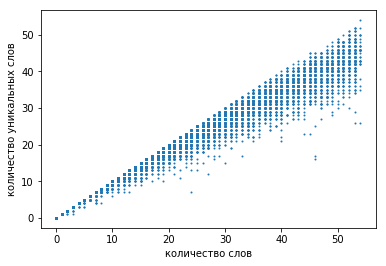

CPU times: user 6.04 s, sys: 9.64 ms, total: 6.05 s
Wall time: 6.05 s


In [47]:
%%time
def clean(sent):
    return ' '.join([word for word in sent.split() if not word in sorted_vocab[0:100]])

data_clean = list(map(clean, new_data))
arr = []
for t in data_clean:
    n_words = len(t.split())
    n_unique = len(Counter(t.split()))
    arr.append((n_words, n_unique))

s = sorted(arr, key=lambda x: x[0])
plt.scatter(*zip(*s[0:10000]), s=1)
plt.xlabel('количество слов')
plt.ylabel('количество уникальных слов')
plt.show()

После удаления 100 самых частых слов, форма немного изменилась, зависимость стала более линейной.

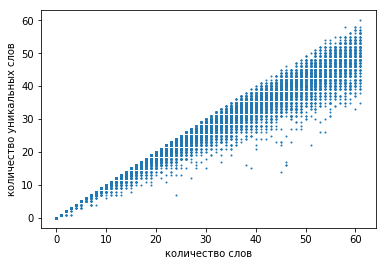

In [48]:
for t in data_stem:
    n_words = len(t.split())
    n_unique = len(Counter(t.split()))
    arr.append((n_words, n_unique))

s = sorted(arr, key=lambda x: x[0])
plt.scatter(*zip(*s[0:18000]), s=1)
plt.xlabel('количество слов')
plt.ylabel('количество уникальных слов')
plt.show()

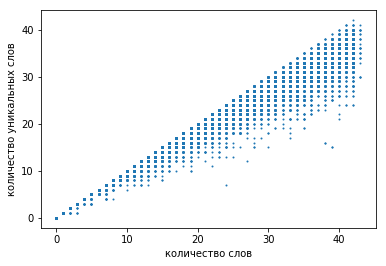

In [49]:
for t in data_lemm:
    n_words = len(t.split())
    n_unique = len(Counter(t.split()))
    arr.append((n_words, n_unique))

s = sorted(arr, key=lambda x: x[0])
plt.scatter(*zip(*s[0:18000]), s=1)
plt.xlabel('количество слов')
plt.ylabel('количество уникальных слов')
plt.show()

Нормализация также сделала зависимость более линейной.

# Метрики

In [51]:
#                   F1-score  Time(s)
# CountVectorizer    0.57

# TfidfVectorizer    0.75     3.32
# +стемминг           0.75     3.07
# +лемматизация        0.75     3.09

# удаление
# 10 частных слов      0.75     2.85
# 100 частных слов     0.75     2.51
# 1000 частных слов    0.73     1.66
# 10000 частных слов   0.56     0.81

# 10 редких слов       0.75     3.19
# 100 редких слов      0.75     3.2
# 1000 редких слов     0.75     3.21
# 10000 редких слов    0.75     3.18

# удаление стоп-слов    0.75     2.27

# использование 2-грамм 0.74     12.9
# использование 3-грамм 0.73     27.9